# Compondo com inteligência
Mateus Augusto Viotto - PC3008967

## Bibliotecas

In [1]:
import numpy as np
from skimage import io, transform, util
import skimage
import cv2
import tensorflow.compat.v1 as tf
import itertools
#from google.colab.patches import cv2_imshow

### Altere para os diretórios correspondentes.

In [27]:
diretorio_imagem = 'img2.png'
diretorio_vocabulario = 'vocabulary_semantic.txt' #ALTERE PARA O DIRETÓRIO DO VOCABULARIO DISPONÍVEL EM https://github.com/OMR-Research/tf-end-to-end/blob/master/Data/vocabulary_semantic.txt
diretorio_modelo = 'model\semantic_model.meta' #ALTERE PARA O DIRETÓRIO DO MODELO DISPONÍVEL EM https://grfia.dlsi.ua.es/primus/models/PrIMuS/Semantic-Model.zip

## Funções ler e salvar

Salva a imagem em formato *jpg* no diretório atual.

In [3]:
def salvar_imagem(imagem, nome):
  io.imsave(nome+'.jpg', imagem)

Lê o vocabulário armazenado no arquito *txt* e armazena em um dicionário.

In [4]:
def ler_vocabulario(diretorio):
  # Abra o arquivo para leitura
  with open(diretorio, 'r') as arquivo:
      # Leia as linhas e armazene em uma lista
      linhas = arquivo.readlines()

  # Cada elemento da lista representa uma linha do arquivo

  dicionario = dict()
  i = 0
  for palavra in linhas:

      dicionario[i] = palavra.replace("\n", "")
      i += 1
  return dicionario


## Funções Pré-processamento

Converte uma imagem colorida para escala de cinza.

In [5]:
def deixar_cinza(imagem):
  return cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

Binariza a imagem utilizando o método *threshold_sauvola*.

In [6]:
def binarizar(image):
  from skimage.filters import threshold_sauvola

  # tamanho da janela de cálculo local do limiar
  window_size = 101

  # fator de sensibilidade
  k = 0.2

  # Calcule o limiar de Sauvola
  threshold = threshold_sauvola(image, window_size=window_size, k=k)

  # Aplique o limiar à imagem para binarizá-la
  binary_image = image > threshold

  return binary_image


Plota um gráfico horizontal da projeção horizontal para visualização da linha de pauta.

In [7]:
def linhadepauta(projection_data):
  import matplotlib.pyplot as plt

  # Combina os arrays em um único array
  combined_data = [item for sublist in projection_data for item in sublist]

  # Define o intervalo de exibição no eixo X
  x_values = range(1, len(combined_data) + 1)  # De 1 a N

  # Define o passo para os rótulos do eixo X (exibe a cada 300 valores)
  x_ticks = list(range(1, len(combined_data) + 1, 50))  # Exibe a cada 300 valores

  # Cria um gráfico de barras horizontais
  plt.barh(x_values, combined_data, color='black')

  # Inverte o eixo Y para que os valores mais altos fiquem no topo
  plt.gca().invert_yaxis()

  # Configura os rótulos do eixo X
  plt.yticks(x_ticks, x_ticks)

  plt.show()

Calcula a projeção horizontal.

In [8]:
def calcular_projecao(img_data, col_row=1):
    # Cria uma máscara onde os valores 0 na imagem original são mapeados para 1, e outros para 0
    mask = np.uint8(np.where(img_data == 0, 1, 0))

    # Calcula a projeção somando os valores na máscara ao longo de uma coluna (col_row=1) ou linha (col_row=0)
    # REDUCE_SUM realiza a soma
    # dtype=cv2.CV_32SC1 define o tipo de dados do resultado como 32 bits com sinal
    count = cv2.reduce(mask, col_row, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

    return count

Rotaciona a imagem.

In [9]:
def girar_imagem(img_data, angle):

  # Rotacionar a imagem
  new_image = util.img_as_ubyte(transform.rotate(img_data, angle, mode='wrap'))

  return new_image

Endireita a imagem, rotacionando-a caso esteja inclinada.

In [10]:
def alinhar_linhas(img_data):
    best_image = None  # Variável para armazenar a melhor imagem alinhada
    maximum = 0  # Variável para armazenar o valor máximo de projeção

    # Loop através de diferentes ângulos de rotação
    for i in range(-40, 40):
        angle = 0.25 * i  # Calcula o ângulo de rotação correspondente

        # Gira a imagem original pelo ângulo calculado
        new_image = girar_imagem(img_data, angle)

        # Binariza a nova imagem (converte para imagem binária)
        binary_image = binarizar(new_image)

        # Calcula a projeção horizontal da imagem binária
        horizontal_projection = calcular_projecao(binary_image)

        # Encontra o valor máximo na projeção horizontal
        max_projection = max(horizontal_projection)

        # Verifica se o valor máximo encontrado é maior que o máximo atual
        if max_projection > maximum:
            best_image = new_image  # Se for maior, atualiza a melhor imagem
            maximum = max_projection  # Atualiza o valor máximo

    return best_image  # Retorna a melhor imagem alinhada

In [11]:
def get_reference_lenghts(img_data):
    black_runs = {}
    white_runs = {}
    for i in range(img_data.shape[1]): # for all columns
        col = img_data[:,i]
        for k, g in itertools.groupby(col):
            length = len(list(g))
            if k == 0:
                black_runs[length] = black_runs.get(length, 0) + 1
            else:
                white_runs[length] = white_runs.get(length, 0) + 1
    line_thickness = max(black_runs, key=black_runs.get)
    staff_space = max(white_runs, key=white_runs.get)
    return(line_thickness, staff_space)

## Funções Identificar Símbolos

In [12]:
def normalize(image):
    return (255. - image)/255.

In [13]:
def resize(image, height):
    width = int(float(height * image.shape[1]) / image.shape[0])
    sample_img = cv2.resize(image, (width, height))
    return sample_img

In [14]:
def sparse_tensor_to_strs(sparse_tensor):
    indices= sparse_tensor[0][0]
    values = sparse_tensor[0][1]
    dense_shape = sparse_tensor[0][2]

    strs = [ [] for i in range(dense_shape[0]) ]

    string = []
    ptr = 0
    b = 0

    for idx in range(len(indices)):
        if indices[idx][0] != b:
            strs[b] = string
            string = []
            b = indices[idx][0]

        string.append(values[ptr])

        ptr = ptr + 1

    strs[b] = string

    return strs

In [15]:
def identificar_simbolos(imagem, vocabulario, diretorio):
    # Desabilita a execução ansiosa
    tf.compat.v1.disable_eager_execution()
    # Cria um novo grafo padrão do TensorFlow
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    # Cria um objeto Saver para importar o modelo
    saver = tf.train.import_meta_graph(diretorio)

    # Restaura os parâmetros do modelo a partir do arquivo
    saver.restore(sess, diretorio[:-5])  # Remove a extensão ".meta" do diretório
    graph = tf.get_default_graph()
    
    # Obter tensores necessários do grafo
    input = graph.get_tensor_by_name("model_input:0")  # Dados de entrada
    seq_len = graph.get_tensor_by_name("seq_lengths:0")  # Comprimento da sequência
    rnn_keep_prob = graph.get_tensor_by_name("keep_prob:0")  # Probabilidade de manter unidades
    height_tensor = graph.get_tensor_by_name("input_height:0")  # Altura da entrada
    width_reduction_tensor = graph.get_tensor_by_name("width_reduction:0")  # Redução de largura
    logits = tf.get_collection("logits")[0]  # Saídas da rede neural (normalmente, saídas da camada softmax)

    # Obter constantes do modelo
    WIDTH_REDUCTION, HEIGHT = sess.run([width_reduction_tensor, height_tensor])

    decoded, _ = tf.nn.ctc_greedy_decoder(logits, seq_len)  # Decodificação CTC

    # Pré-processamento da imagem de entrada
    image = imagem
    image = resize(image, HEIGHT)  # Redimensiona a imagem
    image = normalize(image)  # Normaliza a imagem
    image = np.asarray(image).reshape(1, image.shape[0], image.shape[1], 1)  # Formata a imagem para o modelo

    seq_lengths = [image.shape[2] / WIDTH_REDUCTION]  # Comprimento da sequência

    # Executa a rede neural com a imagem de entrada
    prediction = sess.run(decoded, feed_dict={
        input: image,
        seq_len: seq_lengths,
        rnn_keep_prob: 1.0,
    })

    # Converte a saída da decodificação em texto usando o vocabulário
    str_predictions = sparse_tensor_to_strs(prediction)

    # Retorna a lista de símbolos reconhecidos
    return [vocabulario[w] for w in str_predictions[0]]

## Pré-processamento

### Imagem alinhada e binarizada

In [28]:
imagem = cv2.imread(diretorio_imagem)
imagem_cinza = deixar_cinza(imagem)
imagem_binarizada = binarizar(imagem_cinza)

salvar_imagem(imagem_binarizada, 'binarizada')

C:\Users\mateu\AppData\Local\Temp\ipykernel_2988\1301399296.py:2: UserWarning: binarizada.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(nome+'.jpg', imagem)


In [29]:
imagem_alinhada = alinhar_linhas(imagem_binarizada)
salvar_imagem(imagem_alinhada, 'alinhada')

### Linha de pauta

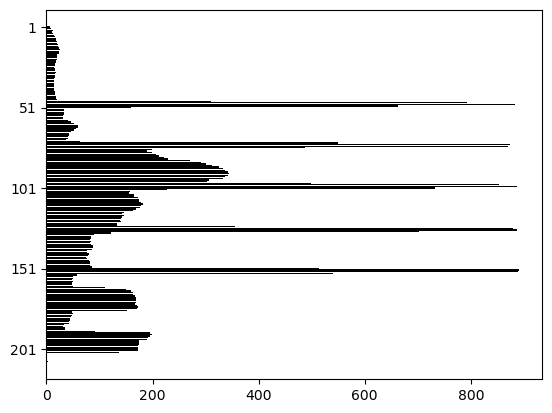

In [30]:
projecao = calcular_projecao(imagem_alinhada)
linhadepauta(projecao)

## Identificar símbolos


In [31]:
vocabulario = ler_vocabulario(diretorio_vocabulario)

In [32]:
# Use a função 'img_as_ubyte' para converter a imagem para ubytes
img_data = skimage.img_as_ubyte(imagem_alinhada)

In [33]:
line_thickness, staff_space = get_reference_lenghts(img_data)

In [34]:
symbols = identificar_simbolos(img_data, vocabulario, diretorio_modelo)

C:\Users\mateu\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model\semantic_model


In [35]:
print(symbols)

['clef-G2', 'timeSignature-C', 'rest-eighth', 'note-C5_eighth', 'note-C5_eighth', 'note-C5_eighth', 'note-C5_eighth', 'note-B4_eighth', 'note-A4_sixteenth', 'note-C5_sixteenth', 'barline', 'note-C5_quarter', 'rest-half', 'barline']


In [36]:
print(len(symbols))

14
